# Setup

In [19]:
import numpy as np
import pandas as pd

import os
import sys

import joblib

# make dir
MODEL_PATH = os.path.join(".", "_models", "svm_exercises")
os.makedirs(MODEL_PATH, exist_ok=True)

# plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# LinearSVC, SVC, and SGDClassifier

Using iris dataset, try to train the three types of models above to produce roughly the same model.
- Load iris dataset into X (input instances), and y (output labels)
    - X should have only two features: petal length and petal width
    - y should have only two labels (for linear separability): virginica or not
- Train LinearSVC on it
- Train SVC using linear kernel on it
- Train SGDClassifier using hinge loss function on it
- Check if the three models are roughly the same
    - Plot our iris dataset on 2D graph
    - Plot the decision boundaries and margins of each model on the same graph

## Load Iris Dataset

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

In [3]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

We want our X to be petal length and petal width.

In [5]:
X = iris.data[:, 2:]
X[:3], iris.data[:3]

(array([[1.4, 0.2],
        [1.4, 0.2],
        [1.3, 0.2]]),
 array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2]]))

In [6]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

We want our y to be virginica or not

In [7]:
y = (iris.target == 2)
y[:3], iris.target[:3]

(array([False, False, False]), array([0, 0, 0]))

In [8]:
X.shape, y.shape

((150, 2), (150,))

Nice!

## Split Train Test Sets

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Let's not touch test set till the models are trained.
- We don't need a validation set because the goal isn't to get great models but to get similar models using different classes.

## Train Models

In [10]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [-3.1802242] [[2.19696307 3.16752928]]
SVC:                          [-3.71602789] [[2.84187135 3.29080461]]
SGDClassifier(alpha=0.00133): [-1.394] [[0.97438163 1.33109798]]


## Plotting :C

In [11]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale (the 10 isn't necessary, just needs to be big enough
# to fill the figure of the plot)
line1 = scaler.inverse_transform([[-10, w1 * -10 + b1], [10, w1 * 10 + b1]])
line2 = scaler.inverse_transform([[-10, w2 * -10 + b2], [10, w2 * 10 + b2]])
line3 = scaler.inverse_transform([[-10, w3 * -10 + b3], [10, w3 * 10 + b3]])

Each line has format:
```
[[x0, y0],
 [x1, y1]]
```
And we plot our x-values from x0 to x1 and y-values from y0 to y1

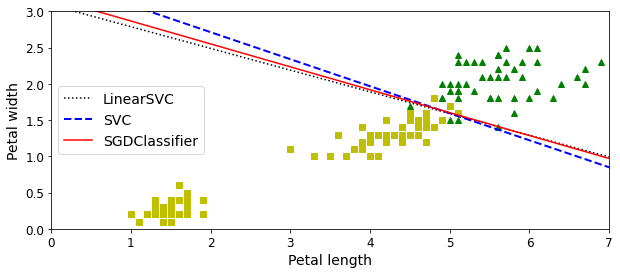

In [12]:
# set figsize
plt.figure(figsize=(10,4))

# X axis is petal length and Y axis is petal width
# plot virginica
plt.plot(X[y, 0], X[y, 1], "g^") # label="Iris virginica"
# plot not-virginica
plt.plot(X[~y, 0], X[~y, 1], "ys") # label="Other"

# plot decision boundaries of models
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")

# Visualization
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3])
plt.show()

These models are indeed roughly the same!

# Train a SVM Classifier for MNIST Dataset

We want to create a high accuracy model for MNIST dataset using SVM classifier.
- Get MNIST dataset from openml
- Split train test set
- Train SVC with rbf kernel and default gamma/C values
- Fine-tune gamma/C values with Grid Search
- Save model

## Get MNIST Dataset

In [13]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]

In [14]:
X.shape, y.shape

((70000, 784), (70000,))

## Split Train Test Sets

In [15]:
X_train, X_test = X[:60000, :], X[60000:, :]
y_train, y_test = y[:60000], y[60000:]

## Train SVC Model

In [17]:
np.unique(y_train[:6000], return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([592, 671, 581, 608, 623, 514, 608, 651, 551, 601]))

Looks like we don't need to use stratified shuffle split.

In [19]:
from sklearn.pipeline import Pipeline

svc_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", gamma="scale")),
])

svc_pipe.fit(X_train[:6000], y_train[:6000])

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(svc_pipe.predict(X_test), y_test)

0.9261

We can do better with some fine-tuning

## Fine-Tune Model

Let's use a smaller set for fine-tuning otherwise it will take forever.
- Use smaller subset to fine-tune gamma and C

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

tuning_index = 1000

param_dist = {
    "svc__gamma": reciprocal(0.001, 0.01),
    "svc__C": uniform(1, 10),
}

rnd_search_cv = RandomizedSearchCV(svc_pipe, param_dist, n_iter=100, verbose=1, cv=3)
rnd_search_cv.fit(X_train[:tuning_index], y_train[:tuning_index])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=100,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffb727ffc40>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffb617063b0>},
                   verbose=1)

In [51]:
rnd_search_cv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=4.613746209128753, gamma=0.0010704845854429843))])

### Save Final Model

In [56]:
# save pipeline
joblib.dump(rnd_search_cv.best_estimator_, os.path.join(MODEL_PATH, "svc_pipeline.pkl"))

['./_models/svm_exercises/svc_pipeline.pkl']

## Evaluate on Test Set

In [20]:
final_pipeline = joblib.load(os.path.join(MODEL_PATH, "svc_pipeline.pkl"))
final_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=4.613746209128753, gamma=0.0010704845854429843))])

Below code takes too long

In [ ]:
# final_pipeline.fit(X_train, y_train)

Accuracy should be pretty high

# Train a SVM Regressor for Housing Dataset

Maybe I will do this, when I need to revisit some fundamentals. But the process of this is the same as training a classifier, just with different data, models, evaluation metrics, and fine-tuning parameters.
- Get dataset (already preprocessed)
- Split into train test
- Train SVR model
    - Scale with StandardScaler
    - Evaluate using MSE
- Fine-tune hyperparameters
- Evaluate on test set